Install additional packages

In [1]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-v1fe103x
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-v1fe103x
  Resolved https://github.com/tensorflow/docs to commit 7d9aab3abb979d304e768df250b7fd069d60497e
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=184416 sha256=b17e81ebc8b67ca4293c3cb0bee9eb0cb4be85f039270958937411e4356ca576
  Stored in directory: /tmp/pip-ephem-wheel-cache-br1pkscd/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Imports

In [2]:
import glob
import matplotlib.pyplot as plt
import imageio
import numpy as np
import os
import PIL
import time
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

from IPython import display


Parameters

In [3]:
plt.rcParams["figure.figsize"] = (7,7)

In [4]:
IMAGE_SHAPE=(32,32,3)

# Dataset

load dataset

In [5]:
(y_train, _), (y_test,_) = tf.keras.datasets.cifar10.load_data()
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)
y_train = (y_train) / 255.  # Normalize the images to [-1, 1]
y_test = (y_test) / 255.  # Normalize the images to [-1, 1]

170498071/170498071 [==============================] - 75s 0us/step


cutout 

In [6]:
x_train = tf.identity(y_train)
x_test = tf.identity(y_test)

In [7]:
class RandomCutout():
  def __init__(self, mask_size=(16,16), border=(0,0), name = 'random_cutout', **kwargs):
    super(RandomCutout, self).__init__(**kwargs)
    
    self.mask_size = mask_size
    self.border = border

  def __call__(self, image_batch):
      x = tf.shape(image_batch)[1]
      y = tf.shape(image_batch)[2]

      xoffset = tf.cast(tf.math.ceil(self.mask_size[0] / 2.) + self.border[0], dtype=tf.int32)
      yoffset = tf.cast(tf.math.ceil(self.mask_size[1] / 2.) + self.border[1], dtype=tf.int32)
      xmin, xmax = xoffset, x - xoffset
      ymin, ymax = yoffset, y - yoffset

      if xmin < xmax:
        xoffset = tf.random.uniform(shape=[], minval=xmin, maxval=xmax, dtype=tf.dtypes.int32)
      else:
        xoffset = tf.cast(x / 2, dtype=tf.int32)
      if ymin < ymax:
        yoffset = tf.random.uniform(shape=[], minval=ymin, maxval=ymax, dtype=tf.dtypes.int32)
      else:
        yoffset = tf.cast(y / 2, dtype=tf.int32)

      xmin, xmax = xoffset - tf.cast(tf.math.ceil(self.mask_size[0] / 2.), dtype=tf.int32), xoffset + tf.cast(tf.math.ceil(self.mask_size[0] / 2.), dtype=tf.int32)
      ymin, ymax = yoffset - tf.cast(tf.math.ceil(self.mask_size[1] / 2.), dtype=tf.int32), yoffset + tf.cast(tf.math.ceil(self.mask_size[1] / 2.), dtype=tf.int32)

      mask = tfa.image.cutout(tf.zeros_like(image_batch), mask_size=self.mask_size, offset=(yoffset,xoffset), constant_values=1.)
      context = image_batch * (1 - mask)
      random_block = image_batch * mask
      return context, random_block, mask, (ymin, xmin, ymax-ymin, xmax-xmin)

In [8]:
random_cutout = RandomCutout(mask_size=(16,16), border=(2,2))

Input


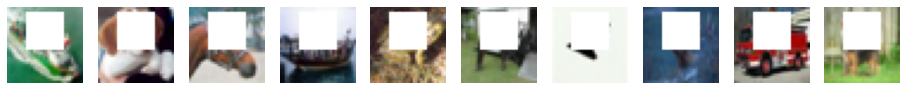

Block


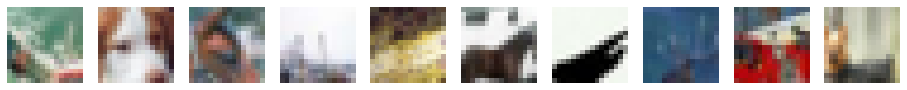

Mask


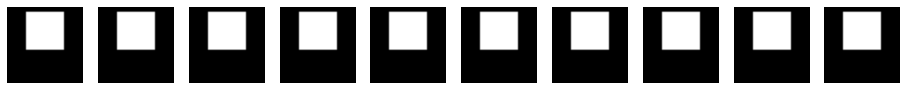

In [9]:
y_batch = y_test[15:25]
context, random_block, mask, coords = random_cutout(y_batch)

fig = plt.figure(figsize=(16,160))
print("Input")
for i, img in enumerate(context + mask):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(16,160))
print("Block")
block = tf.image.crop_to_bounding_box(random_block, *coords)
for i, img in enumerate(block):
    plt.subplot(1,10 ,i+1)
    plt.imshow((img))
    plt.axis('off')

plt.show()

fig = plt.figure(figsize=(16,160))
print("Mask")
for i, img in enumerate(mask):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


# Models


## generator

In [10]:
def Generator(input_shape=(32,32,3)):
    inputs = layers.Input(input_shape)
    filters = 64
    bottleneck = 100

    # Encoder
    x = layers.Conv2D(filters, (4,4), strides=(2,2), padding="same")(inputs) 
    x = layers.LeakyReLU(alpha=0.2)(x)

    if input_shape[0] == 128:
      x = layers.Conv2D(filters, (4,4), strides=(2,2), padding="same")(x)
      x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(filters*2, (4,4), strides=(2,2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(filters*4, (4,4), strides=(2,2), padding="same")(x) 
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(filters*8, (4,4), strides=(2,2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    # BOTTLENECK

    x = layers.Conv2D(bottleneck, (4,4), strides=(2,2), padding="same")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    
    # Decoder
    x = layers.Conv2DTranspose(filters*8, (4,4), strides=(2,2), padding="same")(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(filters*4, (4,4), strides=(2,2), padding="same")(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(filters*2, (4,4), strides=(2,2), padding="same")(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(filters*1, (4,4), strides=(2,2), padding="same")(x) 
    x = layers.ReLU()(x)

    if input_shape[0] == 128:
      x = layers.Conv2DTranspose(filters*1, (4,4), strides=(2,2), padding="same")(x)
      x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(3, (4,4), strides=(2, 2), padding='same')(x)
    outputs = tf.clip_by_value(x, 0., 1.) # obcinają wartości zamiast używać funkcji aktywacji typu tanh czy sigmooid

    model = tf.keras.Model(inputs, outputs, name="Generator")

    return model

generator = Generator()
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         524544    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 256)         0 

## discriminator

In [11]:
def Discriminator(input_shape=(16,16,3)):
    inputs = layers.Input((input_shape))
    filters = 64
    x = layers.Conv2D(filters, (4,4), strides=2, padding="same", name="conv1")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(filters*2, (4,4), strides=2, padding="same", name="conv2")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(filters*4, (4,4), strides=2, padding="same", name="conv3")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Conv2D(filters*8, (4,4), strides=1, padding="same", name="conv4")(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

    x = layers.Flatten()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs, name="Discriminator")
    return model

discriminator = Discriminator()
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 8, 8, 64)          3136      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 conv2 (Conv2D)              (None, 4, 4, 128)         131200    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 4, 4, 128)         0         
                                                                 
 conv3 (Conv2D)              (None, 2, 2, 256)         524544    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 2, 2, 256)       

Input


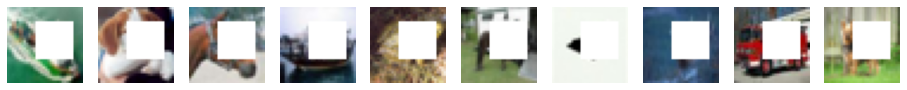

Block


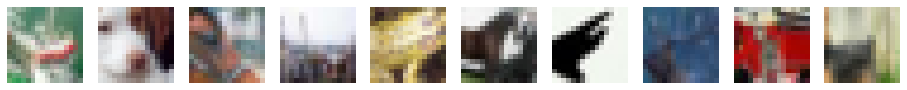

Mask


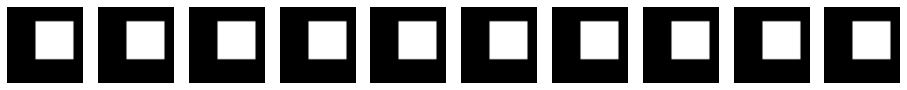

Output


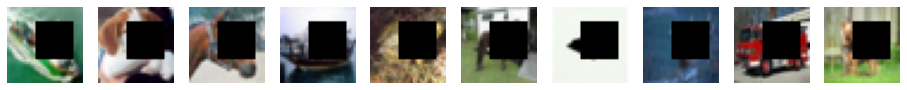

In [12]:
test_batch = y_test[15:25]
context, random_block, mask, coords = random_cutout(test_batch)
context_white = context + mask
inpainted = context + generator(context_white)*mask

fig = plt.figure(figsize=(16,160))
print("Input")
for i, img in enumerate(context + mask):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

fig = plt.figure(figsize=(16,160))
print("Block")
block = tf.image.crop_to_bounding_box(random_block, *coords)
for i, img in enumerate(block):
    plt.subplot(1,10 ,i+1)
    plt.imshow((img))
    plt.axis('off')

plt.show()

fig = plt.figure(figsize=(16,160))
print("Mask")
for i, img in enumerate(mask):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


fig = plt.figure(figsize=(16,160))
print("Output")
for i, img in enumerate(inpainted):
    plt.subplot(1,10 ,i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()



## metrics

In [13]:
class psnr_metric(tf.keras.metrics.Metric):
    def __init__(self, name = 'psnr', **kwargs):
        super(psnr_metric, self).__init__(**kwargs)
        self.value = self.add_weight('value', initializer = 'zeros')
        self.count = self.add_weight('count', initializer = 'zeros')

    def update_state(self, y_true, y_pred,sample_weight=None):
        self.value.assign_add(tf.reduce_mean(tf.image.psnr(y_true, y_pred, 2)))
        self.count.assign_add(1)

    def reset_state(self):
        self.value.assign(0)
        self.count.assign(0)

    def result(self):
        return self.value / self.count

psnr = psnr_metric()

test_batch = y_test[:25]
context, random_block, mask, cords = random_cutout(test_batch)

reconstructed = context+generator(context)*mask


psnr(test_batch,reconstructed)

<tf.Tensor: shape=(), dtype=float32, numpy=17.400276>

In [14]:
class ssim_metric(tf.keras.metrics.Metric):
    def __init__(self, name = 'ssim', **kwargs):
        super(ssim_metric, self).__init__(**kwargs)
        self.value = self.add_weight('value', initializer = 'zeros')
        self.count = self.add_weight('count', initializer = 'zeros')

    def update_state(self, y_true, y_pred,sample_weight=None):
        self.value.assign_add(tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2)))
        self.count.assign_add(1)

    def reset_state(self):
        self.value.assign(0)
        self.count.assign(0)

    def result(self):
        return self.value / self.count

ssim = ssim_metric()

test_batch = y_test[:25]
context, random_block, mask, cords = random_cutout(test_batch)
reconstructed = context+generator(context)*mask

ssim(test_batch,reconstructed)

<tf.Tensor: shape=(), dtype=float32, numpy=0.32876387>

# Context encoder class

In [37]:
class WGAN(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self, 
                  discriminator,
                  generator,
                  generator_extra_steps=1,
                  discriminator_extra_steps=1,
                  mask_size=(16,16),
                  border=(2,2),
                  gp_weight=10.0,
                  name="wgan"):
      super(WGAN, self).__init__()

      self.discriminator = discriminator
      self.generator = generator

      self.d_steps = discriminator_extra_steps
      self.g_steps = generator_extra_steps

      self.psnr_metric = psnr_metric(name="psnr")
      self.ssim_metric = ssim_metric(name="ssim")
      self.gp_weight = gp_weight

      self.random_cutout = RandomCutout(mask_size, border)


    def compile(self, generator_optimizer, discriminator_optimizer, discriminator_loss, adversarial_loss, reconstruction_loss, lam=0.99):
      super(WGAN, self).compile()
      self.generator_optimizer = generator_optimizer
      self.discriminator_optimizer = discriminator_optimizer
      self.adversarial_loss = adversarial_loss
      self.reconstruction_loss = reconstruction_loss
      self.discriminator_loss = discriminator_loss
      self.lam = lam

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        # metrics = super().metrics
        # metrics.append(self.psnr_metric)
        return [self.psnr_metric, self.ssim_metric]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        # norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))  # collapse
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3])+1e-12)
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @tf.function
    def test_step(self, data):
      if isinstance(data, tuple):
            x_batch = data[0]
            y_batch = data[1]

      context, random_region, mask, coords = self.random_cutout(x_batch)
      context_white = context + mask
      real_images = y_batch
      batch_size = tf.shape(y_batch)[0]

      # Generate fake images from the latent vector
      generated = self.generator(context_white, training=False)
      fake_images = context + generated * mask

      fake_block = tf.image.crop_to_bounding_box(fake_images, *coords)
      real_block = tf.image.crop_to_bounding_box(real_images, *coords)
      # Get the logits for the fake images
      fake_logits = self.discriminator(fake_block, training=False)
      # Get the logits for the real images
      real_logits = self.discriminator(real_block, training=False)

      # Calculate the discriminator loss using the fake and real image logits
      d_cost = self.discriminator_loss(real_logits, fake_logits)
      # Calculate the gradient penalty
      gp = self.gradient_penalty(batch_size,real_block, fake_block)
      # Add the gradient penalty to the original discriminator loss
      d_loss = d_cost + gp * self.gp_weight

      # Calculate the generator loss
      g_loss = self.lam * self.reconstruction_loss(real_block, fake_block) + (1-self.lam) * self.adversarial_loss(fake_logits)

      self.psnr_metric.update_state(real_images,fake_images)
      self.ssim_metric.update_state(real_images,fake_images)
      return {"g_loss": g_loss,"d_loss": d_loss, "psnr": self.psnr_metric.result(), "ssim": self.ssim_metric.result()}


    @tf.function
    def train_step(self, data):
      if isinstance(data, tuple):
            x_batch = data[0]
            y_batch = data[1]

      context, random_region, mask, coords = self.random_cutout(x_batch)
      context_white = context + mask
      real_images = y_batch
      batch_size = tf.shape(y_batch)[0]

      for i in range(self.d_steps):
        with tf.GradientTape() as tape:
          # Generate fake images from the latent vector
          generated = self.generator(context_white, training=True)
          fake_images = context + generated * mask

          fake_block = tf.image.crop_to_bounding_box(fake_images, *coords)
          real_block = tf.image.crop_to_bounding_box(real_images, *coords)
          # Get the logits for the fake images
          fake_logits = self.discriminator(fake_block, training=True)
          # Get the logits for the real images
          real_logits = self.discriminator(real_block, training=True)

          # Calculate the discriminator loss using the fake and real image logits
          d_cost = self.discriminator_loss(real_logits, fake_logits)
          # Calculate the gradient penalty
          gp = self.gradient_penalty(batch_size, real_block, fake_block)
          # Add the gradient penalty to the original discriminator loss
          d_loss = d_cost + gp * self.gp_weight

        # Get the gradients w.r.t the discriminator loss
        d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update the weights of the discriminator using the discriminator optimizer
        self.discriminator_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))

      for i in range(self.g_steps):
        with tf.GradientTape() as tape:
          generated = self.generator(context_white, training=True)
          fake_images = context + generated * mask
          fake_block = tf.image.crop_to_bounding_box(fake_images, *coords)
          real_block = tf.image.crop_to_bounding_box(real_images, *coords)
          # Get the discriminator logits for fake images
          gen_img_logits = self.discriminator(fake_block, training=True)
          # Calculate the generator loss
          g_loss = self.lam * self.reconstruction_loss(real_block, fake_block) + (1-self.lam) * self.adversarial_loss(fake_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.generator_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))

      # Compute our own metrics
      self.psnr_metric.update_state(real_images,fake_images)
      self.ssim_metric.update_state(real_images,fake_images)
      return {"g_loss": g_loss,"d_loss": d_loss, "psnr": self.psnr_metric.result(), "ssim": self.ssim_metric.result()}

# Compile

## loss

In [38]:
test_batch = y_test[:25]
context, random_region, mask, coords = random_cutout(test_batch)
reconstructed = context+generator(context)*mask

In [39]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()


In [40]:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

fake_block = tf.image.crop_to_bounding_box(reconstructed, *coords)
real_block = tf.image.crop_to_bounding_box(test_batch, *coords)
discriminator_loss(discriminator(real_block, training=False), discriminator(fake_block, training=False))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0013891459>

In [41]:
def adv_loss(fake_preds):
  return cross_entropy(tf.ones_like(fake_preds), fake_preds)

def rec_loss(y_true, y_pred):
  # return mse(y_true, y_pred)     # MSE / L2
  return mae(y_true, y_pred)  # MAE / L1

In [42]:
LAM = 0.999

fake_block = tf.image.crop_to_bounding_box(reconstructed, *coords)
real_block = tf.image.crop_to_bounding_box(test_batch, *coords)
# generator_loss(discriminator(fake_block, training=False), test_batch, reconstructed)
generator_loss =  LAM * rec_loss(real_block, fake_block) + (1 - LAM) * adv_loss(discriminator(fake_block, training=False))
print(generator_loss)

tf.Tensor(0.49867564, shape=(), dtype=float32)


## optimizers

In [49]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)

LR = 0.00002
BETA1 = 0.9
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=BETA1)            # 3e-4
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=BETA1)       # 3e-5

## model compile

In [50]:
MASK_SIZE = (16,16)
BORDER = (2,2)
wgan = WGAN(discriminator=Discriminator(), 
                         generator= Generator(),
                         discriminator_extra_steps=3, gp_weight=10,
                         mask_size=MASK_SIZE,
                         border=BORDER)

wgan.compile(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    discriminator_loss=discriminator_loss,
    adversarial_loss = adv_loss,
    reconstruction_loss=rec_loss,
    lam = 0.999)

# Training

In [51]:
images_to_show = x_test[:25]
print(images_to_show.shape)

(25, 32, 32, 3)


In [52]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, images_to_show=None, save_every=1,mask_size=(16,16),border=(8,8)):
        self.images_to_show = images_to_show
        self.save_every = save_every
        self.random_cutout = RandomCutout(mask_size, border)
        print(self.images_to_show.shape)

    def on_epoch_end(self, epoch, logs=None):
      if (epoch + 1) % self.save_every == 0:
        
        context, random_region, mask, coords = self.random_cutout(self.images_to_show)
        
        context_white = context + mask
        generated = self.model.generator(context_white, training=False)

        reconstructed_images = context + generated * mask

        plt.ioff()
        fig = plt.figure()
        plt.suptitle(f"epoch:{epoch+1}")
        for i in range(reconstructed_images.shape[0]):
            plt.subplot(5,5, i+1)
            plt.imshow(reconstructed_images[i])
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
        plt.close(fig)

show_images = GANMonitor(images_to_show=images_to_show, save_every=1, mask_size=(16,16), border=(8,8))

(25, 32, 32, 3)


In [53]:
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.discriminator_optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.discriminator_optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.discriminator_optimizer.lr, scheduled_lr)
        if scheduled_lr != lr:
          print("\nEpoch %d: Learning rate is %6.4f." % (epoch+1, scheduled_lr))

LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (40, 1e-5),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

In [54]:
EPOCHS = 30
BATCH_SIZE = 128
history = wgan.fit(x=x_train,
                      y=y_train,
                      validation_data=(x_test, y_test),
                      epochs=EPOCHS, 
                      initial_epoch = 0,
                      batch_size = BATCH_SIZE,
                      shuffle=True, 
                      callbacks=[show_images, CustomLearningRateScheduler(lr_schedule)])

Epoch 1/30
391/391 [==============================] - 104s 175ms/step - g_loss: 0.2081 - d_loss: 0.9083 - psnr: 23.3928 - ssim: 0.5566 - val_g_loss: 0.1955 - val_d_loss: 0.0500 - val_psnr: 25.6620 - val_ssim: 0.6225
Epoch 2/30
391/391 [==============================] - 67s 172ms/step - g_loss: 0.1736 - d_loss: 0.1345 - psnr: 25.9857 - ssim: 0.6409 - val_g_loss: 0.1753 - val_d_loss: -0.0765 - val_psnr: 26.1335 - val_ssim: 0.6517
Epoch 3/30
391/391 [==============================] - 67s 172ms/step - g_loss: 0.1648 - d_loss: 1.3410 - psnr: 26.2701 - ssim: 0.6506 - val_g_loss: 0.1958 - val_d_loss: 0.3345 - val_psnr: 26.3646 - val_ssim: 0.6631
Epoch 4/30
391/391 [==============================] - 68s 173ms/step - g_loss: 0.1624 - d_loss: -0.0669 - psnr: 26.5523 - ssim: 0.6557 - val_g_loss: 0.1768 - val_d_loss: -0.1861 - val_psnr: 26.7076 - val_ssim: 0.6705
Epoch 5/30
391/391 [==============================] - 67s 172ms/step - g_loss: 0.1574 - d_loss: -0.0868 - psnr: 26.6285 - ssim: 0.6666 -

# Visualization

## plots

In [55]:
## Plot train and validation curves
g_loss = history.history['g_loss']
val_g_loss =  history.history['val_g_loss']

d_loss =  history.history['d_loss']
val_d_loss =  history.history['val_d_loss']

psnr =  history.history['psnr']
val_psnr =  history.history['val_psnr']

ssim =  history.history['ssim']
val_ssim =  history.history['val_ssim']

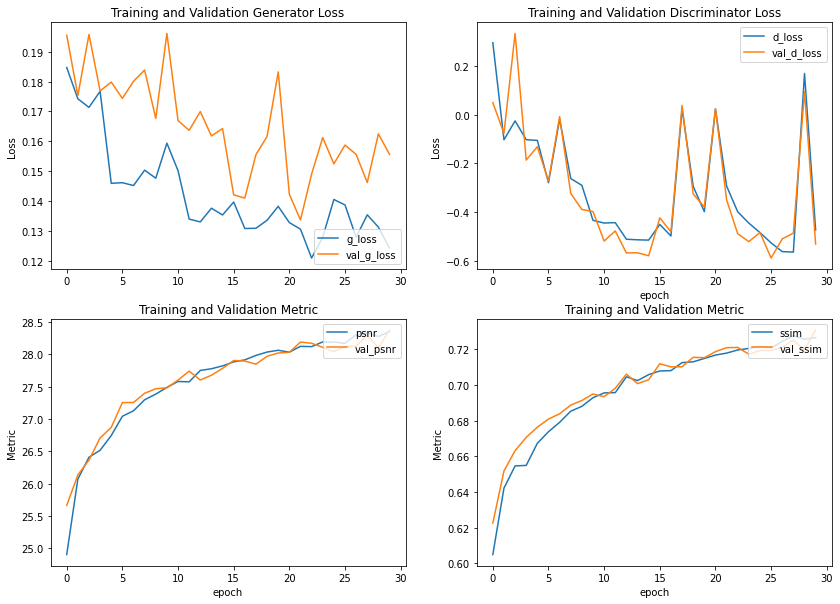

In [64]:
plt.figure(figsize=(14,10))
plt.subplot(2, 2, 1)
plt.plot(g_loss, label='g_loss')
plt.plot(val_g_loss, label='val_g_loss')
plt.legend(loc='lower right')
plt.ylabel('Loss')
# plt.ylim([0,.1])
plt.title('Training and Validation Generator Loss')

plt.subplot(2, 2, 2)
plt.plot(d_loss, label='d_loss')
plt.plot(val_d_loss, label='val_d_loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
# plt.ylim([0,2])
plt.title('Training and Validation Discriminator Loss')
plt.xlabel('epoch')

plt.subplot(2, 2, 3)
plt.plot(psnr, label='psnr')
plt.plot(val_psnr, label='val_psnr')
plt.legend(loc='upper right')
plt.ylabel('Metric')
# plt.ylim([25, 30])
plt.title('Training and Validation Metric')
plt.xlabel('epoch')


plt.subplot(2,2, 4)
plt.plot(ssim, label='ssim')
plt.plot(val_ssim, label='val_ssim')
plt.legend(loc='upper right')
plt.ylabel('Metric')
# plt.ylim([0,1])
plt.title('Training and Validation Metric')
plt.xlabel('epoch')

plt.show()

## last epoch output

In [57]:
history.epoch[-1]

29

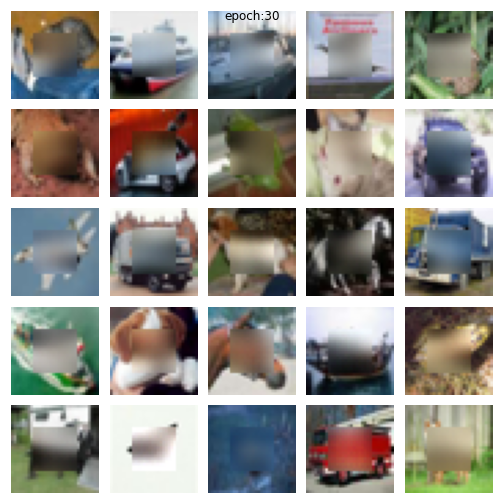

In [58]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(history.epoch[-1]+1)

## gif

In [59]:
anim_file = 'dcgan.gif'

filenames = glob.glob('image*.png')
filenames = sorted(filenames)
frames = []
for i,filename in enumerate(filenames):
  if i % 1 == 0:
    image = imageio.imread(filename)
    frames.append(image)
imageio.mimsave(anim_file, frames, format='GIF', fps=4)



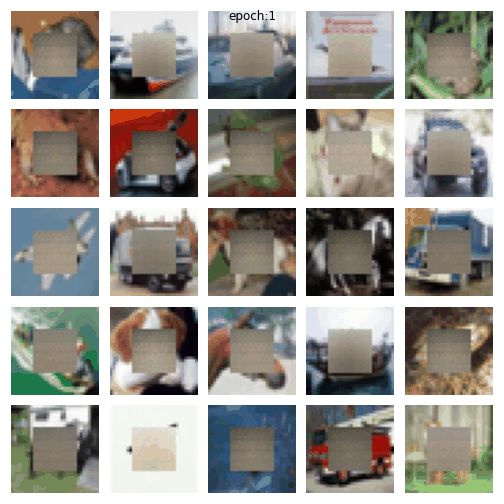

In [60]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
